# MH6212 Group assignment
---
- Arya Gupta​​
- Ding juncheng​
- Hteik Tin Min Pang​​
- Hussain Sakarwala​​
- Ishaa Budonkayala​​
- Nong Minh Hieu​​
- Shivang Singh​​
- Ye Shenghua​
---
**NOTE**: The result may vary upon different runs.

# Mount drive (Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
# Libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# File paths
BASE_DIR = '/content/drive/My Drive/NTU-MH6212/'
DATA_PATH = os.path.join(BASE_DIR, 'dataset/Weather Training Data.csv')

# Columns
NUMERIC_COLUMNS = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
  'Temp9am', 'Temp3pm']
CATEGORICAL_COLUMNS = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
TARGET_COLUMN = 'RainTomorrow'

# Some settings
TEST_RATIO = 0.2

# Load data

In [ ]:
df = pd.read_csv(DATA_PATH)

# Data Imputation

In [ ]:
def data_imputation(df, train=True):
  # Remove ID column
  df                  = df.drop(['row ID'], axis = 1)

  # Fill null with mean
  df['MinTemp']       = df['MinTemp'].fillna(df['MinTemp'].mean())
  df['MaxTemp']       = df['MaxTemp'].fillna(df['MaxTemp'].mean())
  df['Rainfall']      = df['Rainfall'].fillna(df['Rainfall'].mean())
  df['Evaporation']   = df['Evaporation'].fillna(df['Evaporation'].mean())
  df['Sunshine']      = df['Sunshine'].fillna(df['Sunshine'].mean())
  df['WindGustSpeed'] = df['WindGustSpeed'].fillna(df['WindGustSpeed'].mean())
  df['WindSpeed9am']  = df['WindSpeed9am'].fillna(df['WindSpeed9am'].mean())
  df['WindSpeed3pm']  = df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].mean())
  df['Humidity9am']   = df['Humidity9am'].fillna(df['Humidity9am'].mean())
  df['Humidity3pm']   = df['Humidity3pm'].fillna(df['Humidity3pm'].mean())
  df['Pressure9am']   = df['Pressure9am'].fillna(df['Pressure9am'].mean())
  df['Pressure3pm']   = df['Pressure3pm'].fillna(df['Pressure3pm'].mean())
  df['Cloud9am']      = df['Cloud9am'].fillna(df['Cloud9am'].mean())
  df['Cloud3pm']      = df['Cloud3pm'].fillna(df['Cloud3pm'].mean())
  df['Temp9am']       = df['Temp9am'].fillna(df['Temp9am'].mean())
  df['Temp3pm']       = df['Temp3pm'].fillna(df['Temp3pm'].mean())

  # Fill null with most frequent values
  df['WindGustDir']   = df['WindGustDir'].fillna(df['WindGustDir'].value_counts().idxmax())
  df['WindDir9am']    = df['WindDir9am'].fillna(df['WindDir9am'].value_counts().idxmax())
  df['WindDir3pm']    = df['WindDir3pm'].fillna(df['WindDir3pm'].value_counts().idxmax())

  if train: # If train dataset
    # Fill null with value from above's row (a day before)
    df['RainToday']   = df['RainToday'].fillna(df['RainTomorrow'].shift())

    # Change target column's type to numeric
    df['RainToday']   = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
  else: # If test dataset
    # Just drop unlabelled rows
    df                = df.dropna()
  return df

# Apply imputation steps to dataframe
df = data_imputation(df)

# Data preprocessing
In this case-study, we examined two classes of models, parametric/distance-based and tree-based models.

* Tree-based models:
  - Decision Tree.
  - Random Forest.
  - Ada-boosting Tree.

* Parametric/Distance-based:
  - K-Nearest Neighbors.
  - Logistic Regression.

For parametric/distance-based models, we will scale the numerical features and one-hot encode the categorical features while performing minimal pre-processing for tree-based models.


## 1. Preprocessing data for Logistic Regression and KNN

In [ ]:
def preproc_for_knn_and_lr(df, scale='standard'):
  # One-hot encode categorical features
  cat_onehot = pd.get_dummies(df[CATEGORICAL_COLUMNS])
  target_col = df[TARGET_COLUMN]

  # Scale numerical features
  df_num = df[NUMERIC_COLUMNS]
  if scale == 'standard':
    num_scaled = StandardScaler().fit_transform(df_num)
  elif scale == 'minmax':
    num_scaled = MinMaxScaler().fit_transform(df_num)
  num_scaled = pd.DataFrame(num_scaled, index=df_num.index, columns=df_num.columns)

  # Combine data
  df_final = pd.concat ([num_scaled, cat_onehot, target_col], axis=1)
  return df_final

# Apply preprocessing steps to original data
df_tilde = preproc_for_knn_and_lr(df.copy())

## 2. Preprocessing for Tree-based models

In [ ]:
# Initialize Encoders
Location_enc = LabelEncoder()
WindGustDir_enc = LabelEncoder()
WindDir9am_enc = LabelEncoder()
WindDir3pm_enc = LabelEncoder()

# Encode
df['Location'] = Location_enc.fit_transform(df['Location'])
df['WindGustDir'] = WindGustDir_enc.fit_transform(df['WindGustDir'])
df['WindDir9am'] = WindDir9am_enc.fit_transform(df['WindDir9am'])
df['WindDir3pm'] = WindDir3pm_enc.fit_transform(df['WindDir3pm'])

# Data splitting

In [ ]:
def train_test_split_idx(df):
  # Randomly select training indices
  num_train = int(len(df) * (1 - TEST_RATIO))
  train_idx = random.sample(range(len(df)), num_train)
  test_idx  = list(set(range(len(df))).difference(set(train_idx)))
  return train_idx, test_idx

In [ ]:
# Get train and test indices
train_idx, test_idx = train_test_split_idx(df)

# Split the data - for tree models
X1 = df.drop([TARGET_COLUMN], axis=1)
Y1 = df[TARGET_COLUMN]
X1_train, X1_test, Y1_train, Y1_test = X1.loc[train_idx], X1.loc[test_idx], Y1.loc[train_idx], Y1.loc[test_idx]

# Split the data - scaled and onehot-encoded dataframe
X2 = df_tilde.drop([TARGET_COLUMN], axis=1)
Y2 = df_tilde[TARGET_COLUMN]
X2_train, X2_test, Y2_train, Y2_test = X2.loc[train_idx], X2.loc[test_idx], Y2.loc[train_idx], Y2.loc[test_idx]

# Common functions for evaluations

In [ ]:
def evaluate_model(y_true, y_pred_prob, y_pred_label):
  # Computation
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
  auc = roc_auc_score(y_true, y_pred_prob)

  # Visualization
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))

  ## 1. The ROC curve
  ax[0].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
  ax[0].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
  ax[0].set_xlabel('False Positive Rate')
  ax[0].set_ylabel('True Positive Rate')
  ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
  ax[0].legend(loc='lower right')
  ax[0].grid()

  ## 2. Confusion matrix
  class_labels = ['Not Rain', 'Rain']
  cm1 = confusion_matrix(y_true, y_pred_label)
  ax[1] = sns.heatmap(cm1, annot=True, ax=ax[1], fmt="d", cmap="Blues", cbar=False)
  ax[1].set_xticklabels(class_labels, rotation=45)
  ax[1].set_yticklabels(class_labels, rotation=0)
  ax[1].set_title('Confusion Matrix')
  plt.show()

  ## 3. Classification Report
  print(classification_report(y_true, y_pred_label, target_names=class_labels))


# Modelling

## 1. Logistic Regression

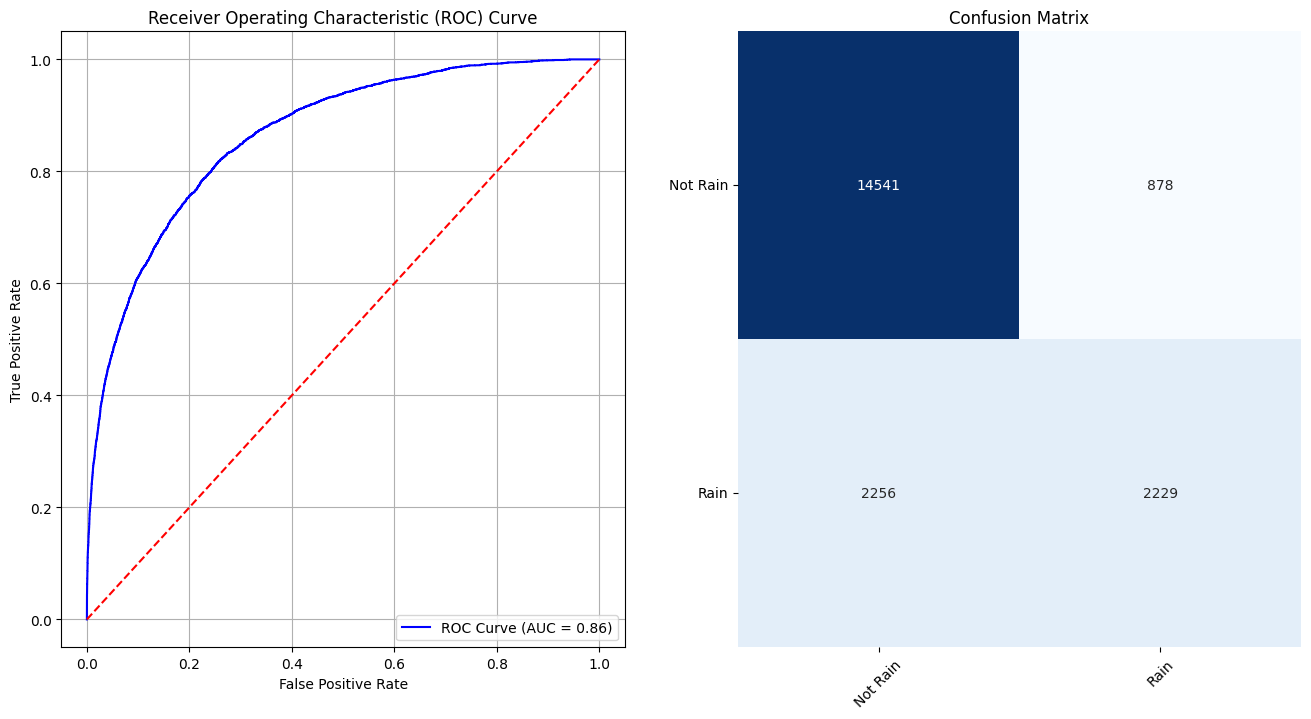

              precision    recall  f1-score   support

    Not Rain       0.87      0.94      0.90     15419
        Rain       0.72      0.50      0.59      4485

    accuracy                           0.84     19904
   macro avg       0.79      0.72      0.74     19904
weighted avg       0.83      0.84      0.83     19904



In [ ]:
# Build
logreg = LogisticRegression(max_iter=400)
logreg.fit(X2_train, Y2_train)
y_pred_prob = logreg.predict_proba(X2_test)[:, 1]
y_pred_label = logreg.predict(X2_test)

# Evaluate
evaluate_model(Y2_test, y_pred_prob, y_pred_label)

## 2. Decision Tree

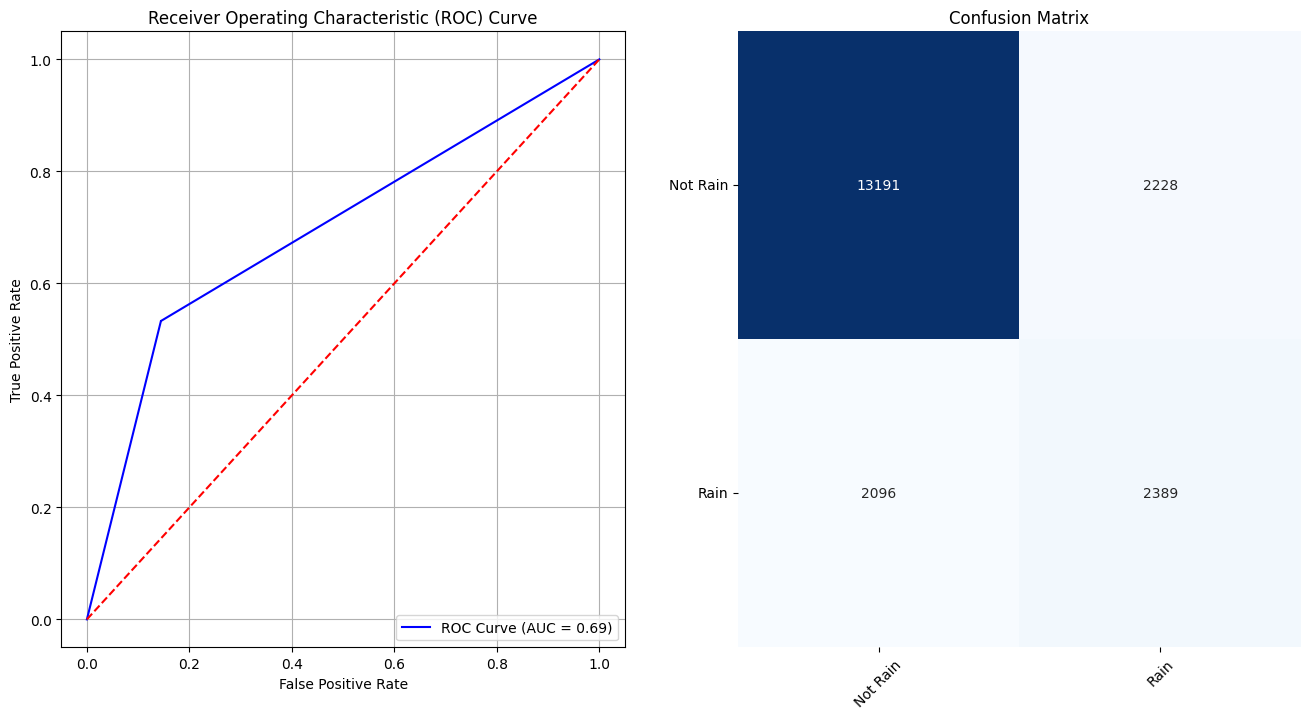

              precision    recall  f1-score   support

    Not Rain       0.86      0.86      0.86     15419
        Rain       0.52      0.53      0.52      4485

    accuracy                           0.78     19904
   macro avg       0.69      0.69      0.69     19904
weighted avg       0.79      0.78      0.78     19904



In [ ]:
# Build
dtree = DecisionTreeClassifier()
dtree.fit(X1_train, Y1_train)
y_pred_prob = dtree.predict_proba(X1_test)[:, 1]
y_pred_label = dtree.predict(X1_test)

# Evaluate
evaluate_model(Y1_test, y_pred_prob, y_pred_label)

## 3. Random Forest

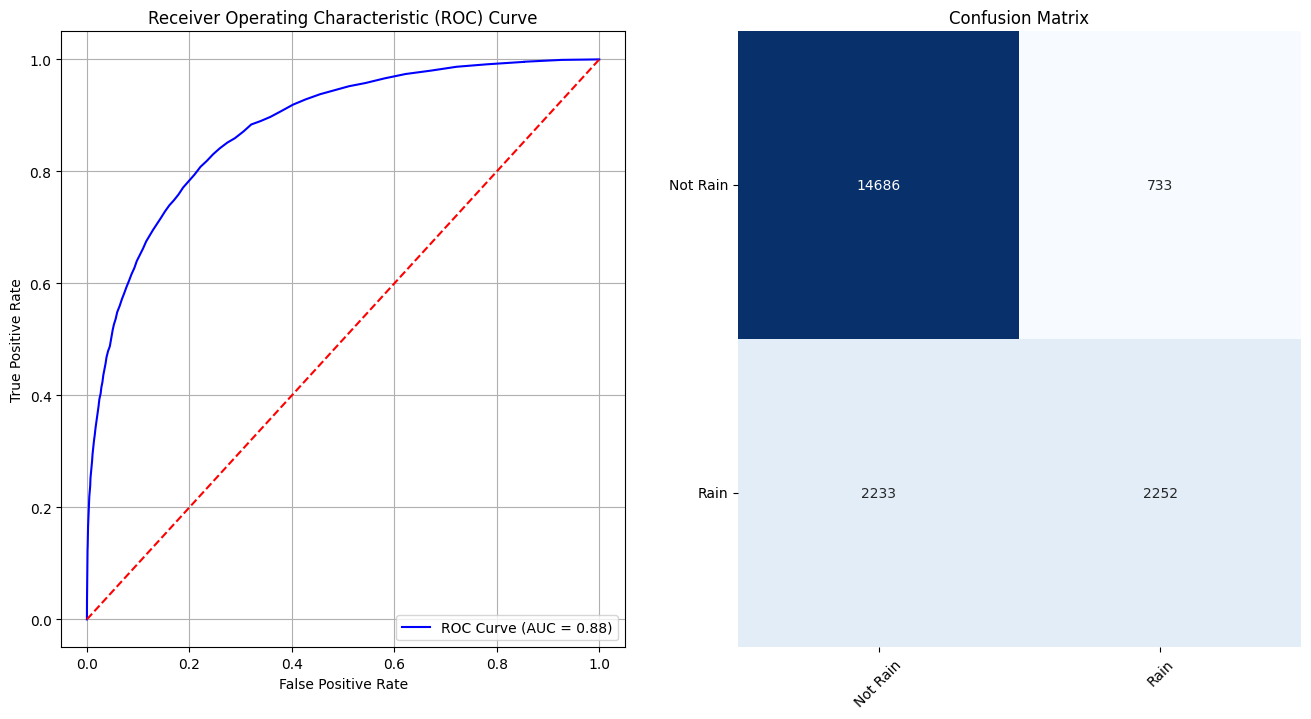

              precision    recall  f1-score   support

    Not Rain       0.87      0.95      0.91     15419
        Rain       0.75      0.50      0.60      4485

    accuracy                           0.85     19904
   macro avg       0.81      0.73      0.76     19904
weighted avg       0.84      0.85      0.84     19904



In [ ]:
# Build
rforest = RandomForestClassifier()
rforest.fit(X1_train, Y1_train)
y_pred_prob = rforest.predict_proba(X1_test)[:, 1]
y_pred_label = rforest.predict(X1_test)

# Evaluate
evaluate_model(Y1_test, y_pred_prob, y_pred_label)

## 4. AdaBoosting Tree

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


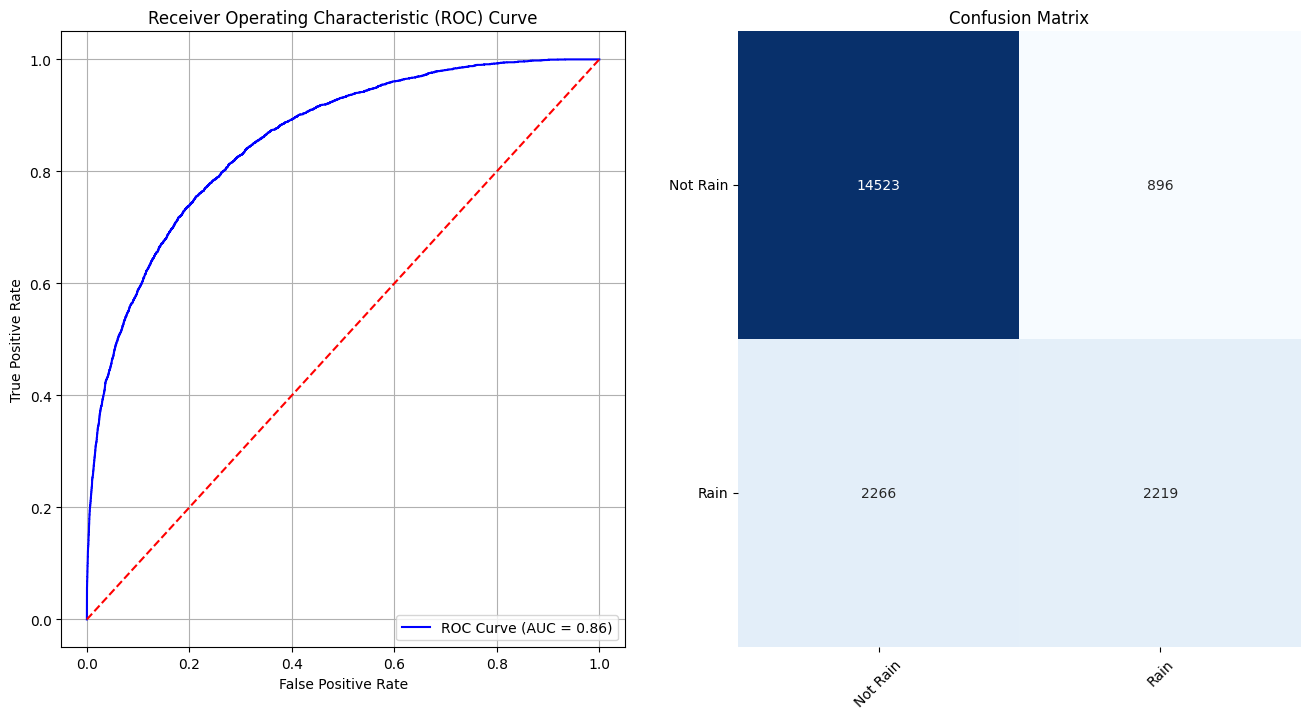

              precision    recall  f1-score   support

    Not Rain       0.87      0.94      0.90     15419
        Rain       0.71      0.49      0.58      4485

    accuracy                           0.84     19904
   macro avg       0.79      0.72      0.74     19904
weighted avg       0.83      0.84      0.83     19904



In [ ]:
# Build
adaboost = AdaBoostClassifier()
adaboost.fit(X1_train, Y1_train)
y_pred_prob = adaboost.predict_proba(X1_test)[:, 1]
y_pred_label = adaboost.predict(X1_test)

# Evaluate
evaluate_model(Y1_test, y_pred_prob, y_pred_label)

## 5. K-Nearest Neighbors

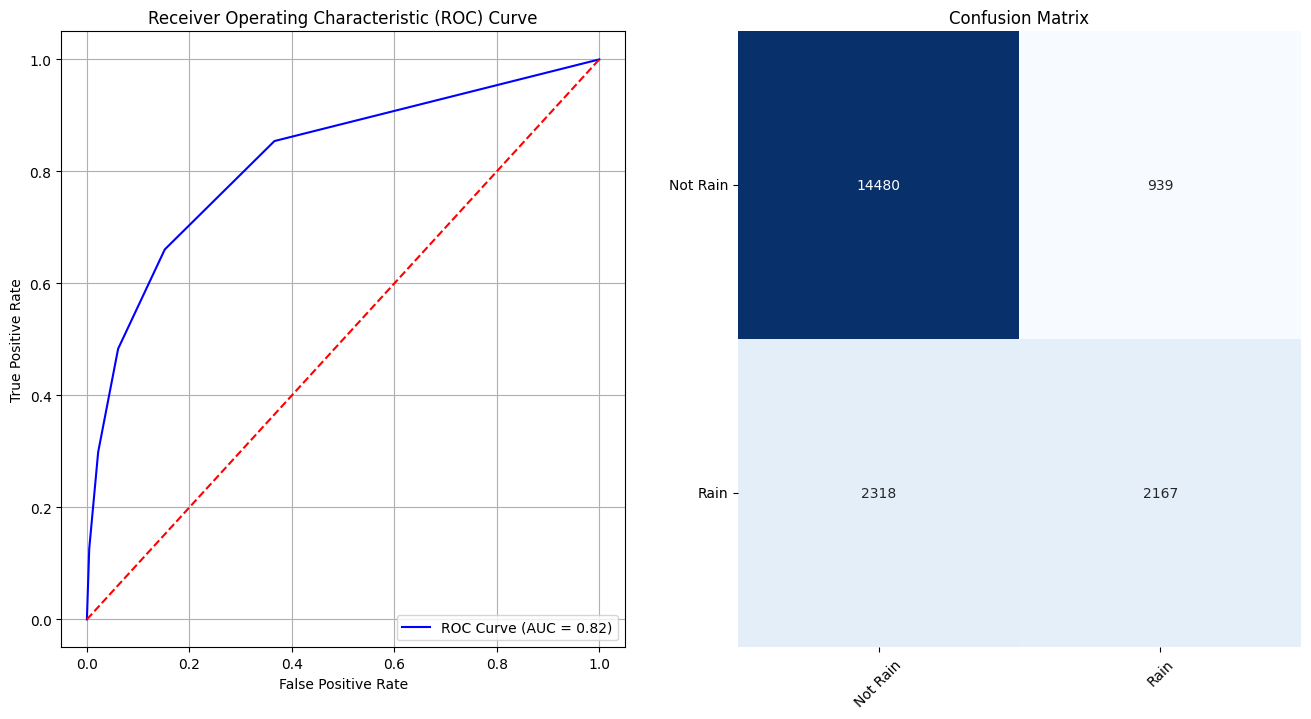

              precision    recall  f1-score   support

    Not Rain       0.86      0.94      0.90     15419
        Rain       0.70      0.48      0.57      4485

    accuracy                           0.84     19904
   macro avg       0.78      0.71      0.73     19904
weighted avg       0.82      0.84      0.83     19904



In [ ]:
# Build
knn = KNeighborsClassifier()
knn.fit(X2_train, Y2_train)
y_pred_prob = knn.predict_proba(X2_test)[:, 1]
y_pred_label = knn.predict(X2_test)

# Evaluate
evaluate_model(Y2_test, y_pred_prob, y_pred_label)

# Hyper-parameters tuning (Random Forest)

## 1. Start GridSearchCV

In [ ]:
n_estimators = [100, 150, 200]
max_depth = [10, 15, 20]
criterion = ['gini', 'entropy']
bootstrap = [True,False]
max_features = ['auto', 'sqrt']
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 2, 3]

parameters = dict(n_estimators = n_estimators, max_depth = max_depth,
              criterion = criterion, bootstrap = bootstrap,
              max_features = max_features,
              min_samples_split = min_samples_split,
              min_samples_leaf = min_samples_leaf)

rforest = RandomForestClassifier()
rftuned = GridSearchCV(rforest, parameters, cv = 3, verbose = 2)
rfbest = rftuned.fit(X1_train, Y1_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=150; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=150; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=150; total time=   0.0s
[CV] END bootstrap=True,

KeyboardInterrupt: 

## 2. Fit best parameters

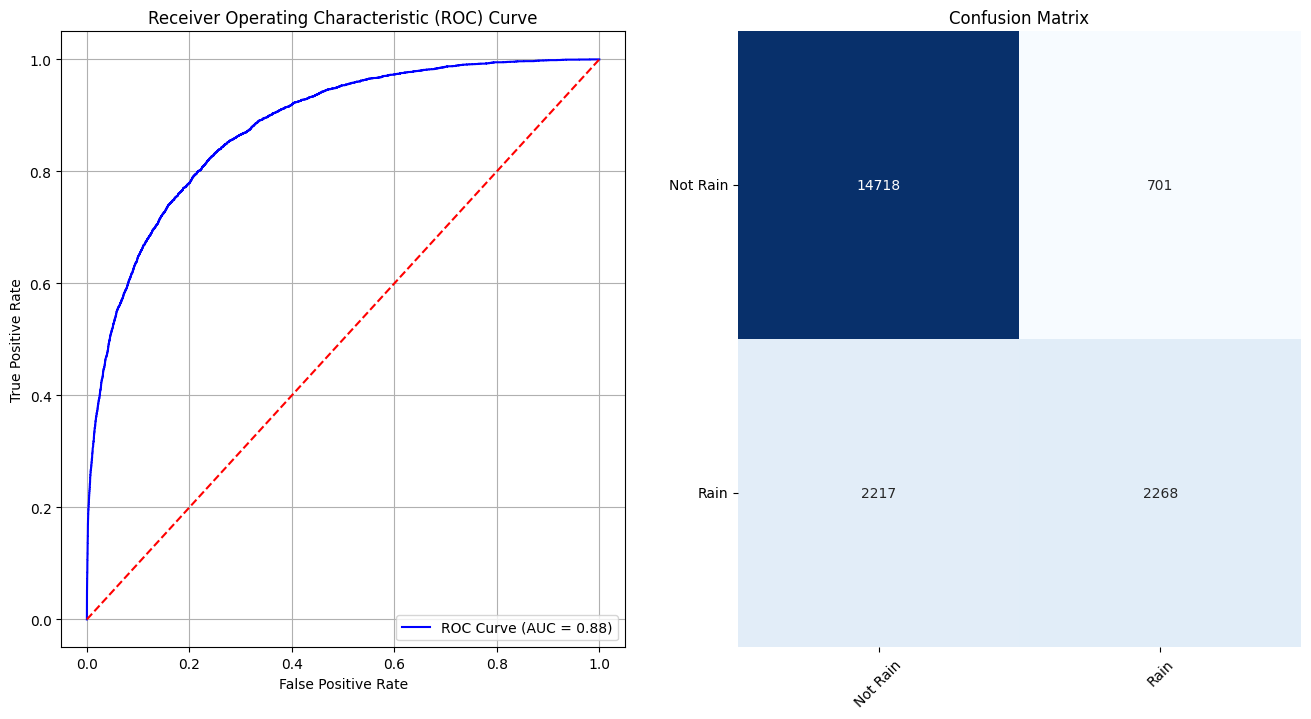

              precision    recall  f1-score   support

    Not Rain       0.87      0.95      0.91     15419
        Rain       0.76      0.51      0.61      4485

    accuracy                           0.85     19904
   macro avg       0.82      0.73      0.76     19904
weighted avg       0.85      0.85      0.84     19904



In [ ]:
# Found using a strong computer of our member (Jun Cheng)
best_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Build
rforest = RandomForestClassifier(**best_params)
rforest.fit(X1_train, Y1_train)
y_pred_prob = rforest.predict_proba(X1_test)[:, 1]
y_pred_label = rforest.predict(X1_test)

# Evaluate
evaluate_model(Y1_test, y_pred_prob, y_pred_label)